## İmport Libary Ana Dataset

import nltk  
    nltk.download('all')

In [27]:
#Stadard Libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#For Ml libary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#For Nlp Libary 
import re
import string
import nltk  
from nltk import LancasterStemmer
from textblob import TextBlob
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Model Savin
from joblib import dump, load
from sklearn.pipeline import Pipeline

#İgnore Error
import warnings
warnings.simplefilter(action="ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [4, 4]
#plt.figure(figsize =(5, 3))

In [28]:
df=pd.read_csv('spam_ham_dataset.csv')

## Check Dataset

In [29]:
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [31]:
df.label_num.describe().T#%50 Data values 0 important

count    5171.000000
mean        0.289886
std         0.453753
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label_num, dtype: float64

## Exploratory Data Analysis

In [32]:
df.shape

(5171, 4)

In [33]:
#Null Check
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Unnamed: 0,0,0.0
label,0,0.0
text,0,0.0
label_num,0,0.0


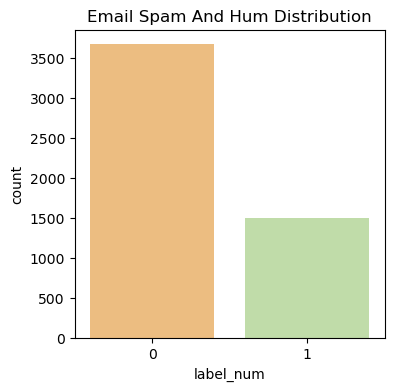

In [34]:
sns.countplot(data=df, x="label_num",palette="Spectral").set(title="Email Spam And Hum Distribution");

In [35]:
df.label.value_counts(normalize=True)

ham     0.710114
spam    0.289886
Name: label, dtype: float64

In [36]:
df.label_num.value_counts(normalize=True)

0    0.710114
1    0.289886
Name: label_num, dtype: float64

In [37]:
df['Unnamed: 0']#İt is an unstructured

0        605
1       2349
2       3624
3       4685
4       2030
        ... 
5166    1518
5167     404
5168    2933
5169    1409
5170    4807
Name: Unnamed: 0, Length: 5171, dtype: int64

In [38]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)#Delting Unnamed 0

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [40]:
#Duplicate value?
df['text'].duplicated().value_counts()

False    4993
True      178
Name: text, dtype: int64

In [41]:
df.drop_duplicates(subset=['text'],inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      4993 non-null   object
 1   text       4993 non-null   object
 2   label_num  4993 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 156.0+ KB


## Pre Procressing NLP

In [43]:
df.text[10]

"Subject: vocable % rnd - word asceticism\r\nvcsc - brand new stock for your attention\r\nvocalscape inc - the stock symbol is : vcsc\r\nvcsc will be our top stock pick for the month of april - stock expected to\r\nbounce to 12 cents level\r\nthe stock hit its all time low and will bounce back\r\nstock is going to explode in next 5 days - watch it soar\r\nwatch the stock go crazy this and next week .\r\nbreaking news - vocalscape inc . announces agreement to resell mix network\r\nservices\r\ncurrent price : $ 0 . 025\r\nwe expect projected speculative price in next 5 days : $ 0 . 12\r\nwe expect projected speculative price in next 15 days : $ 0 . 15\r\nvocalscape networks inc . is building a company that ' s revolutionizing the\r\ntelecommunications industry with the most affordable phone systems , hardware ,\r\nonline software , and rates in canada and the us . vocalscape , a company with\r\nglobal reach , is receiving international attention for the development of voice\r\nover ip ( 

<p>Text Datat Result<p>
-  punctuation marks.
-  numeric value.
- short words like 're'.

<p> Removing words with numeric value in comments
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
# Remove punctuation and convert all words to lowercase
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower()) 

#Remove Special Character
def remove_special_characters(self, dataframe):
    self.log.info("Removing special characters from dataframe")
    no_special_characters = dataframe.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    return no_special_characters

#Remove Whitespace
def remove_whitespace(self, dataframe):
    self.log.info("Removing whitespace from dataframe")
    # replace more than 1 space with 1 space
    merged_spaces = dataframe.str.replace(r"\s\s+",' ')
    # delete beginning and trailing spaces
    trimmed_spaces = merged_spaces.apply(lambda x: x.str.strip())
    return trimmed_spaces

#Remove Website link
def remove_website_links(self, dataframe):
    self.log.info("Removing website links from dataframe")
    no_website_links = dataframe.str.replace(r"http\S+", "")
    return no_website_links
#Remove Email adress
def remove_emails(self, dataframe):
    no_emails = dataframe.str.replace(r"\S*@\S*\s?")
    return no_emails

#Lookup function edits word abbreviations
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"im": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [46]:

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


df['cleanText']=df['text'].map(lambda s:preprocess(s)) 

In [47]:
# Removing words with numeric value in comments
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
# Remove punctuation and convert all words to lowercase
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower()) 
#remove '\r\n'
df['text']=df['text'].replace(r'\r\n', ' ', regex=True) 

In [48]:
df['text'] = df['text'].map(alphanumeric).map(punc_lower)

In [49]:
%%time
def correct(text):
    text = [str(TextBlob(word).correct()) for word in text.split(' ')]
    text = " ".join(text)
    return text

df['text'] = df['text'].apply(correct)

Wall time: 2h 55min 12s


In [50]:
#Word short than 1
df['text']= df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

In [51]:
df.text[10]

'subject movable and word asceticism vast brand new stock for your attention vocalscape in the stock symbol is vast vast will be our top stock pick for the month of april stock expected to bounce to cents level the stock hit its all time low and will bounce back stock is going to explode in next days watch it soar watch the stock go crazy this and next week breaking news vocalscape in announces agreement to retell mix network services current price we expect projected speculative price in next days we expect projected speculative price in next days vocalscape network in is building company that revolutionizing the telecommunication industry with the most unfordable phone systems hardware online software and rates in canada and the us vocalscape company with global reach is receiving international attention for the development of voice over in void application solutions including the award winning eyefontm softphone for real time pp to phone we are an advanced implements of pox systems 

## Split and Tokenization

In [52]:
X=df.text
y=df.label_num

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42)

In [53]:
## Countvectorized

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)


pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names_out()).head()

,aabvmmq,aachecar,aaigrcrb,aaihmqv,aaldano,aambique,aamlrg,aaron,aashqcsny,aaxrzm,...,zxklh,zxzmcnbf,zyjvit,zykfe,zynsdirnh,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzocb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
## TFIDF-Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out()).head()

,aabvmmq,aachecar,aaigrcrb,aaihmqv,aaldano,aambique,aamlrg,aaron,aashqcsny,aaxrzm,...,zxklh,zxzmcnbf,zyjvit,zykfe,zynsdirnh,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzocb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Evolution

In [55]:
#Logistic regression CountVectorizer
lgcv=LogisticRegression(solver="liblinear")

lgcv.fit(X_train_cv, y_train)
Y_predlgcv = lgcv.predict(X_test_cv)

acc_lgcv_train = round(lgcv.score(X_train_cv, y_train) * 100, 2)

In [56]:
#Logistic Regression Tfidf
lgtf=LogisticRegression(solver="liblinear")


lgtf.fit(X_train_tfidf, y_train)
Y_predlgtf = lgtf.predict(X_test_tfidf)

acc_lgtf_train = round(lgtf.score(X_train_tfidf, y_train) * 100, 2)

In [57]:
#MultinomialNB Counvectorizer AND Tfid
mnbcv = MultinomialNB()
mnbcv.fit(X_train_cv, y_train)

mnbtf = MultinomialNB()
mnbtf.fit(X_train_tfidf, y_train)

y_pred_cv_mnb = mnbcv.predict(X_test_cv)
y_pred_tf_mnb = mnbtf.predict(X_test_tfidf)

acc_mnbcv_train = round(mnbcv.score(X_train_cv, y_train) * 100, 2)
acc_mnbtf_train = round(mnbtf.score(X_train_tfidf, y_train) * 100, 2)

In [58]:
#BernoulNB Counvectorizer AND Tfid

bnbcv = BernoulliNB()
bnbcv.fit(X_train_cv, y_train)

bnbtf = BernoulliNB()
bnbtf.fit(X_train_tfidf, y_train)

y_pred_cv_bnb = bnbcv.predict(X_test_cv)
y_pred_tf_bnb = bnbtf.predict(X_test_tfidf)

acc_bnbcv_train = round(bnbcv.score(X_train_cv, y_train) * 100, 2)
acc_bnbtf_train = round(bnbtf.score(X_train_tfidf, y_train) * 100, 2)


In [59]:
xgb = XGBClassifier()
xgbcv=xgb.fit(X_train_cv, y_train)

xgb = XGBClassifier()
xgbtf=xgb.fit(X_train_tfidf, y_train)

y_pred_cv_xgb = xgbcv.predict(X_test_cv)
y_pred_tf_xgb = xgbtf.predict(X_test_tfidf)

acc_xgbcv_train = round(xgbcv.score(X_train_cv, y_train) * 100, 2)
acc_xgbtf_train = round(xgbtf.score(X_train_tfidf, y_train) * 100, 2)

In [74]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Multinomial Naive Bayes ', 
               'Bernoulli Naive Bayes ', 'XGBoost Classifier'],
    'Test Counter Vecterized': [acc_lgcv_train, acc_mnbcv_train, acc_bnbcv_train, acc_xgbcv_train
                                ],
    'Test TFID Vectorizer': [acc_lgtf_train, acc_mnbtf_train, acc_bnbtf_train, acc_xgbtf_train
                          ]})

result_df = results.sort_values(by='Test TFID Vectorizer', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Test Counter Vecterized,Test TFID Vectorizer
Model,,
Logistic Regression,99.97,99.66
XGBoost Classifier,99.71,99.66
Multinomial Naive Bayes,98.74,97.31
Bernoulli Naive Bayes,87.41,86.67


In [61]:
#Confisuan matrix

def conf_matrix(actual, predicted):
    plt.figure(figsize=[8,8])
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'], annot=True,
                fmt='d', annot_kws={'fontsize':35}, cmap="YlGnBu", square=True);

    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted,pos_label='Positive', zero_division=1)
    recall = recall_score(actual, predicted, pos_label='Negative', zero_division=1)
    f1 = f1_score(actual, predicted, pos_label='Negative', zero_division=1)
    # pos_label parametresi precision, recall ve f1 score unu görmek istediğimiz labelı soruyor
    # zero_division parametresi 0'a bölme işlemini gerçekleşirse uyarı verip vermeyeceğini soruyor (1=uyarı verme)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

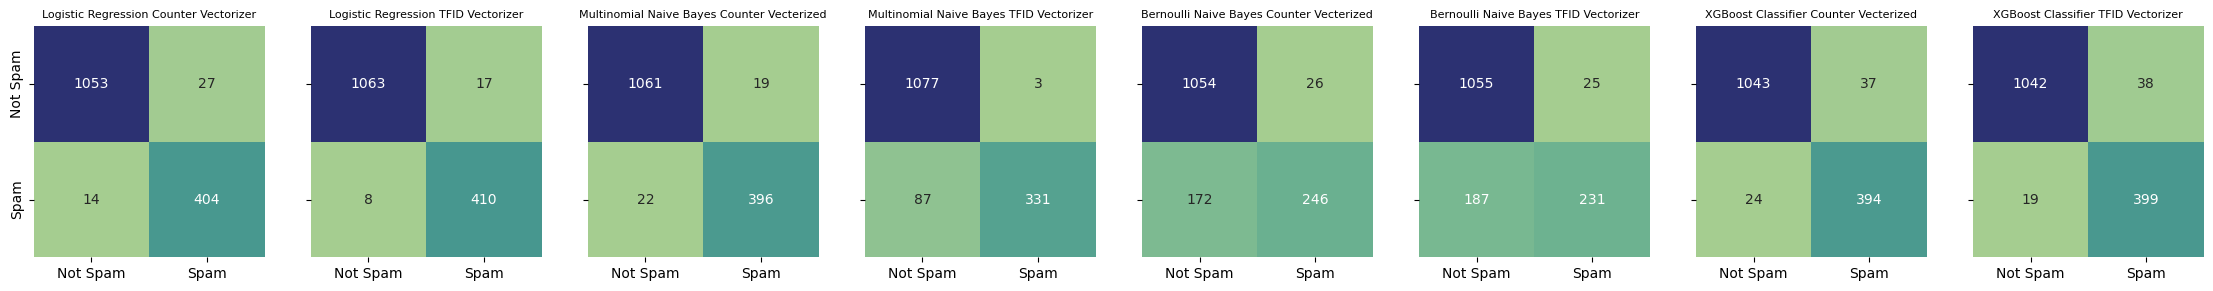

In [62]:
cmlgcv  =  confusion_matrix(y_test, Y_predlgcv)
cmlgtf  =  confusion_matrix(y_test, Y_predlgtf)
cmmnbcv =  confusion_matrix(y_test, y_pred_cv_mnb)
cmmnbtf =  confusion_matrix(y_test, y_pred_tf_mnb)
cmbnbcv =  confusion_matrix(y_test, y_pred_cv_bnb)
cmbnbtf =  confusion_matrix(y_test, y_pred_tf_bnb)
cmxgbcv =  confusion_matrix(y_test, y_pred_cv_xgb)
cmxgbtf =  confusion_matrix(y_test, y_pred_tf_xgb)

classifiers = {'Logistic Regression Counter Vectorizer':cmlgcv, 
               'Logistic Regression TFID Vectorizer':cmlgtf,
               'Multinomial Naive Bayes Counter Vecterized':cmmnbcv,
               'Multinomial Naive Bayes TFID Vectorizer':cmmnbtf,
               'Bernoulli Naive Bayes Counter Vecterized':cmbnbcv,
               'Bernoulli Naive Bayes TFID Vectorizer':cmbnbtf,
               'XGBoost Classifier Counter Vecterized':cmxgbcv,
               'XGBoost Classifier TFID Vectorizer':cmxgbtf,
}

fig, axn = plt.subplots(1,8, sharey='row',figsize=(28,3))

for i, ax in enumerate(axn.flat):
    k = list(classifiers)[i]
    sns.heatmap(classifiers[k], ax=ax, annot = True, cmap = 'crest', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
    ax.set_title(k,fontsize=8)

In [63]:
#rlgcv  =  classification_report(y_test, Y_predlgcv)
#rlgtf  =  classification_report(y_test, Y_predlgtf)
#rmnbcv =  classification_report(y_test, y_pred_cv_mnb)
#rmnbtf =  classification_report(y_test, y_pred_tf_mnb)
#rbnbcv =  classification_report(y_test, y_pred_cv_bnb)
#rbnbtf =  classification_report(y_test, y_pred_tf_bnb)
#rxgbcv =  classification_report(y_test, y_pred_cv_xgb)
#rxgbtf =  classification_report(y_test, y_pred_tf_xgb)


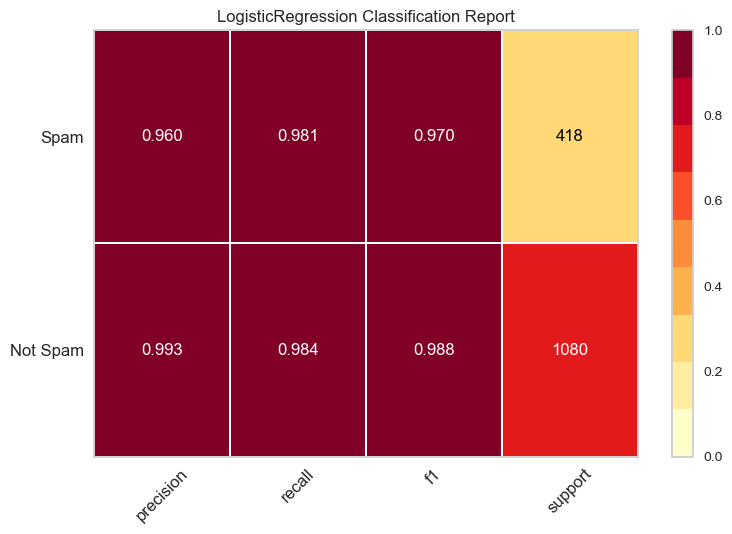

In [64]:
from yellowbrick.classifier import ClassificationReport

classes = ["Not Spam", "Spam"]

# Instantiate the visualizer
visualizer = ClassificationReport(lgtf,classes=classes, support=True)
visualizer.fit(X_train_tfidf, y_train)        # Fit the visualizer and the model
visualizer.score(X_test_tfidf, y_test)        # Evaluate the model on the test data
plt.rcParams['figure.figsize'] = [6, 4]
visualizer.show();    

## Conclusion
I find 410 spam mails and choose Logistic regression TFID Vectorizer the result.**

In [65]:
# LogisticRegression Pipeline
pipe_lr = Pipeline(steps=[('Tf',TfidfVectorizer()),('lr',LogisticRegression())])

In [66]:
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('Tf', TfidfVectorizer()), ('lr', LogisticRegression())])

In [67]:
pipe_lr.score(X_test,y_test)

0.9759679572763685

In [68]:
ext="This email spam"

In [69]:
pipe_lr.predict([ext])

array([1], dtype=int64)

In [70]:
pipe_lr.predict_proba([ext])

array([[0.23828856, 0.76171144]])

In [71]:
pipe_lr.classes_

array([0, 1], dtype=int64)

In [72]:
dump(pipe_lr, 'smap_mail_lr.pkl')

['smap_mail_lr.pkl']